## Image classification vs Object detection vs Image segmentation
<img src="https://media.discordapp.net/attachments/763819251249184789/857822034045567016/image.png">
<br><br>

## Image annotation: assigning labels
<br>

## Popular datasets: ImageNet, COCO, Google Open Images
## Tensorflow hub has pre-train models

## Sliding window approch for object detection (Single Shot MultiBox Detector)
- ### Keep on sliding a smaller window on the test image until find a match
- ### Trial and error to find the right window size
- ### Cons: too much calculation & bounding box shape maybe not accurate

## *Therefore there are faster algorithms:*

## R CNN (Retina-Net) --> Fast R CNN --> Faster R CNN --> YOLO (you only look once)

# YOLO
<img src="https://media.discordapp.net/attachments/763819251249184789/857843667619676190/image.png?width=1845&height=1182" width=700>
<br>

- ### Divide a image to multiple grid cells (usually 19 x 19)
- ### An Object is in a specific cell only when the center coords of the box lie in that cell
- ### Eliminates the bounding boxes using IoU (Intersection over Union: Overlapping area) to get the highest possibility one
- ### Duplicate step # 3 until only 1 bounding box left (Non max supression)
- ### If multiple objects belongs to one cell, we concatenate ancher boxes together (2 vector of size 8 --> 1 vector of size 16)

<br>

### X_train: <br>
image<br><br>

### y_train:

| Name | Explanation |
|:---:|:---:|
| P | Probability of a object in the image | 
| Bx | center of box X coord | 
| By | center of box Y coord | 
| Bw | width | 
| Bh | height | 
| C1 | Is the object belongs to class 1? | 
| C2 | Is the object belongs to class 2? |

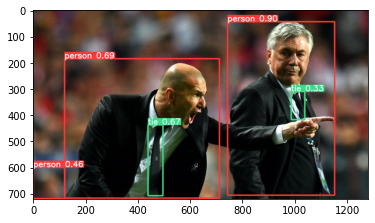

In [40]:
# A simple YOLO v5 demo
import cv2
import pathlib
import numpy as np
from PIL import Image
from yolov5 import YOLOv5
from matplotlib import pyplot as plt
%matplotlib inline

# set model params
model_path = f"{os.path.dirname(os.path.abspath('__file__'))}/yolov5/weights/yolov5s.pt" # it automatically downloads yolov5s model to given path
device = "cuda" # or "cpu"

# init yolov5 model
yolov5 = YOLOv5(model_path, device)

# load images
image1 = 'https://github.com/ultralytics/yolov5/raw/master/data/images/zidane.jpg'
image2 = 'https://github.com/ultralytics/yolov5/blob/master/data/images/bus.jpg'

# perform inference
results = yolov5.predict(image1)

# perform inference with larger input size
results = yolov5.predict(image1, size=1280)

# perform inference with test time augmentation
results = yolov5.predict(image1, augment=True)

# perform inference on multiple images
# results = yolov5.predict([image1, image2], size=1280, augment=True)

# parse results
predictions = results.pred[0]
boxes = predictions[:, :4] # x1, x2, y1, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

# show detection bounding boxes on image
# plt.imshow(np.reshape(results.imgs, (720, 1280, 3))), results.pred


def plot_one_box(x, im, color=(128, 128, 128), label=None, line_thickness=3):
    # Plots one bounding box on image 'im' using OpenCV
    assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

class Colors:
    # Ultralytics color palette https://ultralytics.com/
    def __init__(self):
        # hex = matplotlib.colors.TABLEAU_COLORS.values()
        hex = ('FF3838', 'FF9D97', 'FF701F', 'FFB21D', 'CFD231', '48F90A', '92CC17', '3DDB86', '1A9334', '00D4BB',
               '2C99A8', '00C2FF', '344593', '6473FF', '0018EC', '8438FF', '520085', 'CB38FF', 'FF95C8', 'FF37C7')
        self.palette = [self.hex2rgb('#' + c) for c in hex]
        self.n = len(self.palette)

    def __call__(self, i, bgr=False):
        c = self.palette[int(i) % self.n]
        return (c[2], c[1], c[0]) if bgr else c

    @staticmethod
    def hex2rgb(h):  # rgb order (PIL)
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

colors = Colors()

for i, (im, pred) in enumerate(zip(results.imgs, results.pred)):
    str = f'image {i + 1}/{len(results.pred)}: {im.shape[0]}x{im.shape[1]} '
    if pred is not None:
        for c in pred[:, -1].unique():
            n = (pred[:, -1] == c).sum()  # detections per class
            str += f"{n} {results.names[int(c)]}{'s' * (n > 1)}, "  # add to string

            for *box, conf, cls in pred:  # xyxy, confidence, class
                label = f'{results.names[int(cls)]} {conf:.2f}'
                plot_one_box(box, im, label=label, color=colors(cls))

    im = Image.fromarray(im.astype(np.uint8)) if isinstance(im, np.ndarray) else im  # from np
    plt.imshow(im)